In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.community import LFR_benchmark_graph
from networkx.algorithms import bipartite
import numpy as np
import scipy as sp
from scipy.sparse import coo_array
from scipy import sparse
from cdlib import algorithms
from cdlib import evaluation
import sklearn
from utils import *
from distances import *
from consensus import *
import math
import itertools
import random
import time
from pathlib import Path
from sklearn.metrics.cluster import normalized_mutual_info_score

Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}


## Parameter configurations for clustering generation

In [2]:
n = 1000
expected_clusters = []
for i in range(4):
    expected_clusters.append(random.randint(int(n ** (1. / 3)),3*int(n ** (1. / 2))))
    
alg_params = {
    "label_propagation": None,
    "leiden": None,
    "significance_communities": None,
    "surprise_communities": None,
    "greedy_modularity": None,
    "paris": None,
    "louvain": {
        "resolution": [0.75, 1.0, 1.25, 1.5],
        "randomize": [314159, 2718]
    },
    "infomap": None,
    "walktrap": None,
    "markov_clustering": {
        "inflation": [1.2, 1.5, 2, 2.5],
        "pruning_threshold": [0.01, 0.001],
        "convergence_check_frequency": [100]
    },
    "em": {
        "k": list(expected_clusters)
    },
    "sbm_dl": None,
    "spinglass": {
        "spins": list(expected_clusters)
    },
    "ricci_community": {
        "alpha": [0.3, 0.5, 0.6, 0.75]
    }
}

## Enumerate clusterings

In [3]:
clustering_enumeration = []
count = 0
for alg, params in alg_params.items():
    param_combinations = []
    param_names = []
    if params is not None:
        iterables = []
        param_names = []
        for param in params.keys():
            iterables.append(list(params[param]))
            param_names.append(param)
        param_combinations = list(itertools.product(*iterables))
    if len(param_combinations) > 0:
        for param_combination in param_combinations:
            expr = "algorithms."+alg+"(G"
            for i in range(len(param_names)):
                expr = expr + "," + param_names[i] + "=" + str(param_combination[i])
            expr = expr + ")"
            clustering_enumeration.append((expr,count))
            count = count + 1      
    else:
        expr = "algorithms."+alg+"(G)"
        clustering_enumeration.append((expr,count))
        count = count + 1
print(clustering_enumeration)

[('algorithms.label_propagation(G)', 0), ('algorithms.leiden(G)', 1), ('algorithms.significance_communities(G)', 2), ('algorithms.surprise_communities(G)', 3), ('algorithms.greedy_modularity(G)', 4), ('algorithms.paris(G)', 5), ('algorithms.louvain(G,resolution=0.75,randomize=314159)', 6), ('algorithms.louvain(G,resolution=0.75,randomize=2718)', 7), ('algorithms.louvain(G,resolution=1.0,randomize=314159)', 8), ('algorithms.louvain(G,resolution=1.0,randomize=2718)', 9), ('algorithms.louvain(G,resolution=1.25,randomize=314159)', 10), ('algorithms.louvain(G,resolution=1.25,randomize=2718)', 11), ('algorithms.louvain(G,resolution=1.5,randomize=314159)', 12), ('algorithms.louvain(G,resolution=1.5,randomize=2718)', 13), ('algorithms.infomap(G)', 14), ('algorithms.walktrap(G)', 15), ('algorithms.markov_clustering(G,inflation=1.2,pruning_threshold=0.01,convergence_check_frequency=100)', 16), ('algorithms.markov_clustering(G,inflation=1.2,pruning_threshold=0.001,convergence_check_frequency=100)

### Calculate distance distribution for all benchmark graphs, all conensus methods and all distance metrics

In [ ]:
import os

stats = []

distance_metrics = ["split_joint_distance", "mirkin_distance", "variation_of_info_distance"]
consensus_methods = ["lf", "mcla", "hbgf", "nmf", "v1", "boem", "v2", "v3", "v4", "v5", "v7", "v8"]
#consensus_methods = ["v4"]
ns = [200, 1000, 5000]
mus = [1, 2, 3, 4]
#mus = [2]
gammas = [30]
betas = [11]
for n in ns:
    for mu in mus:
        for gamma in gammas:
            for beta in betas:
                P_list = []
                fileprefix = "LFR/" + "n" + str(n) + "/"
                fname = "LFR_n" + str(n) + "_mu0" + str(mu) + "_gamma" + str(gamma) + "_beta" + str(beta)
                graph_file = fileprefix + fname + ".mtx"
                print(graph_file)
                G = None
                with open(graph_file) as f:
                    G = nx.from_scipy_sparse_array(spio.mmread(f), create_using=nx.Graph)

                    for k in clustering_enumeration:
                        alg_clust_file = fileprefix + fname + "." + str(k[1])
                        alg_partition = None
                        if Path(alg_clust_file).is_file():
                            alg_partition = read_clust_lst(alg_clust_file)

                            for cons_method in consensus_methods:
                                for distance_metric in distance_metrics:
                                    cons_partition = None
                                    optimized_distance = None
                                    cons_clust_file = fileprefix + fname + "." + cons_method
                                    common_stat = {}
                                    common_stat["mu"] = mu
                                    common_stat["n"] = n
                                    common_stat["gamma"] = gamma
                                    common_stat["beta"] = beta
                                    common_stat["alg"] = k[1]
                                    common_stat["cons_method"] = cons_method
                                    common_stat["distance_metric"] = distance_metric

                                    if cons_method in ["best_candidate"]:
                                        """
                                        for optimized_distance in distance_metrics:
                                            cons_partition = read_clust_lst(clust_file_prefix + "." + optimized_distance)
                                            #print(clust_file_prefix + "." + optimized_distance)
                                            stat = dict(common_stat)
                                            stat["optimized_distance"] = optimized_distance
                                            distance = eval(distance_metric)(alg_partition, cons_partition)
                                            stat["distance"] = distance

                                            stats.append(stat)
                                        """
                                        pass
                                    else:
                                         if Path(cons_clust_file).is_file():
                                            # No need to append any extension
                                            cons_partition = read_clust_lst(cons_clust_file)
                                            stat = dict(common_stat)
                                            stat["optimized_distance"] = "none"
                                            distance = eval(distance_metric)(alg_partition, cons_partition)
                                            stat["distance"] = distance

                                            stats.append(stat)

                
df = pd.DataFrame(stats)
filename = "benchmark-consensus-distance-stats.csv"
df.to_csv(filename, index=False, mode='w', header=True)
#df.to_csv(filename, index=False, mode='a', header=not os.path.exists(filename))

LFR/n200/LFR_n200_mu01_gamma30_beta11.mtx
LFR/n200/LFR_n200_mu02_gamma30_beta11.mtx
LFR/n200/LFR_n200_mu03_gamma30_beta11.mtx
LFR/n200/LFR_n200_mu04_gamma30_beta11.mtx
LFR/n1000/LFR_n1000_mu01_gamma30_beta11.mtx
LFR/n1000/LFR_n1000_mu02_gamma30_beta11.mtx
LFR/n1000/LFR_n1000_mu03_gamma30_beta11.mtx
LFR/n1000/LFR_n1000_mu04_gamma30_beta11.mtx
LFR/n5000/LFR_n5000_mu01_gamma30_beta11.mtx
LFR/n5000/LFR_n5000_mu02_gamma30_beta11.mtx
LFR/n5000/LFR_n5000_mu03_gamma30_beta11.mtx


### Plot distance distributions

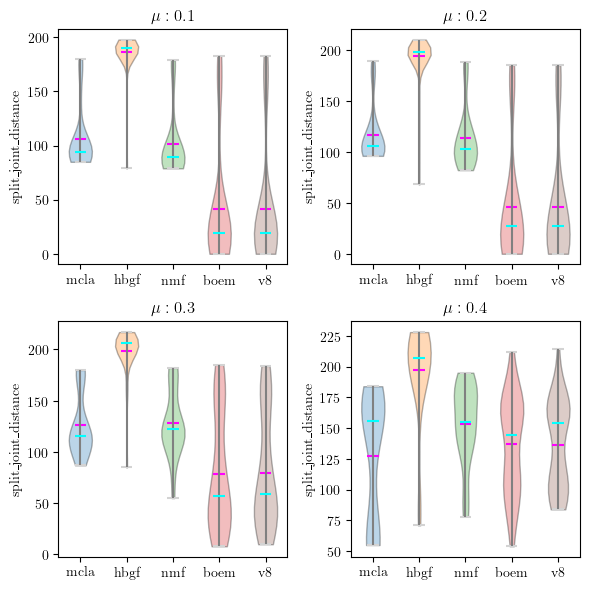

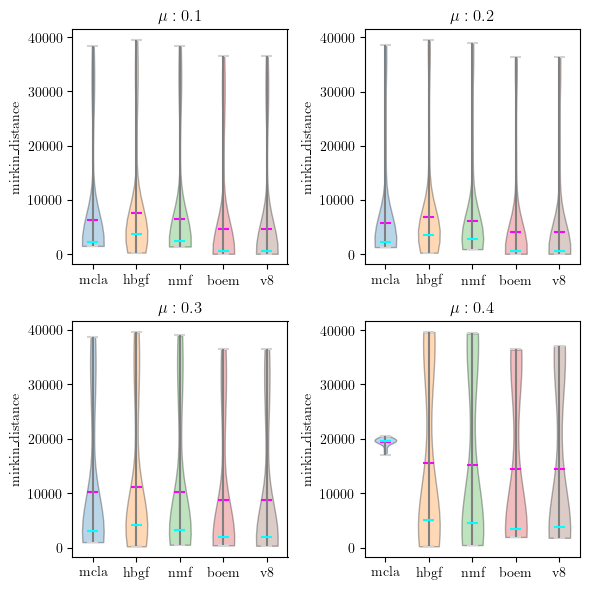

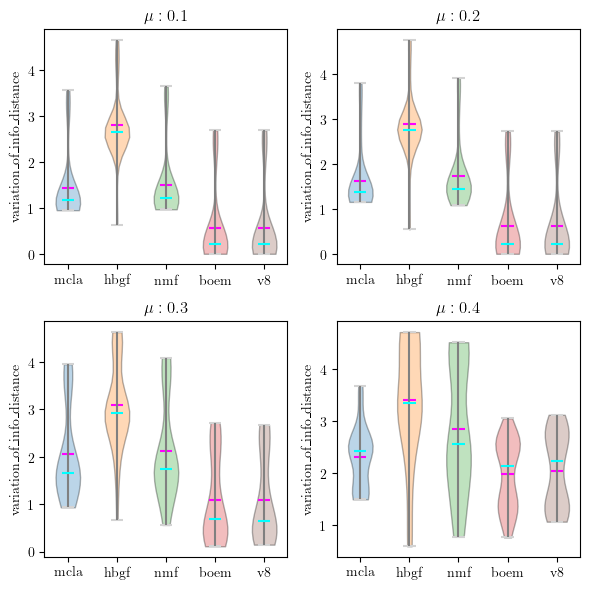

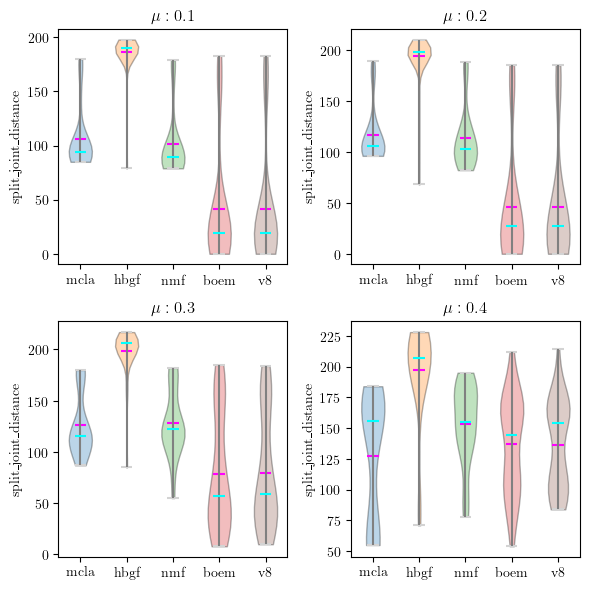

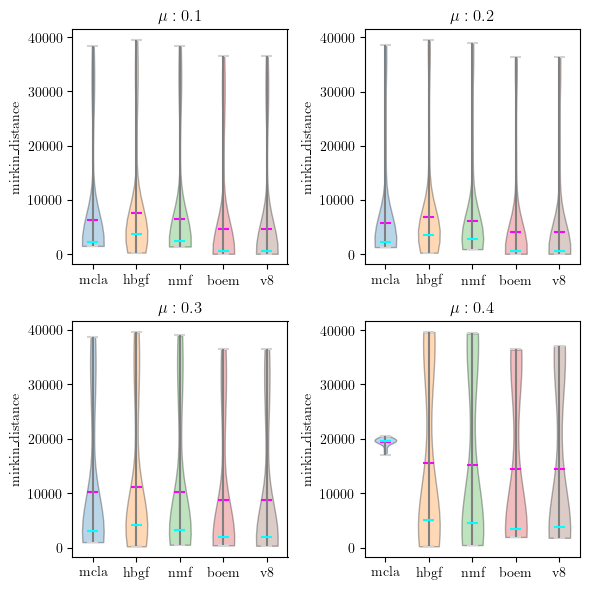

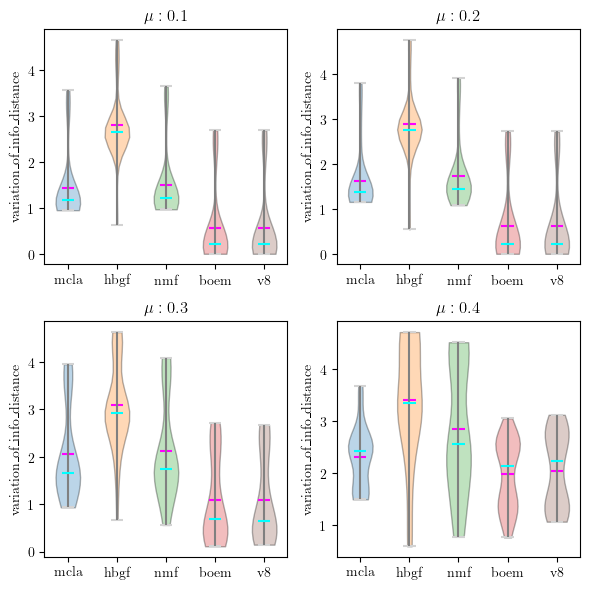

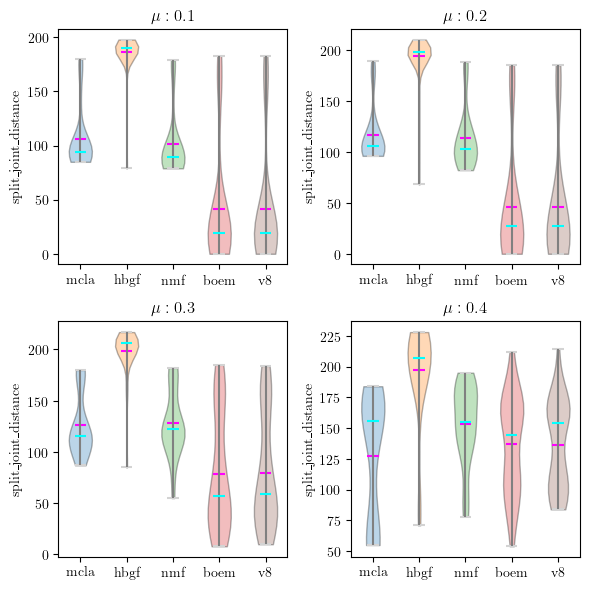

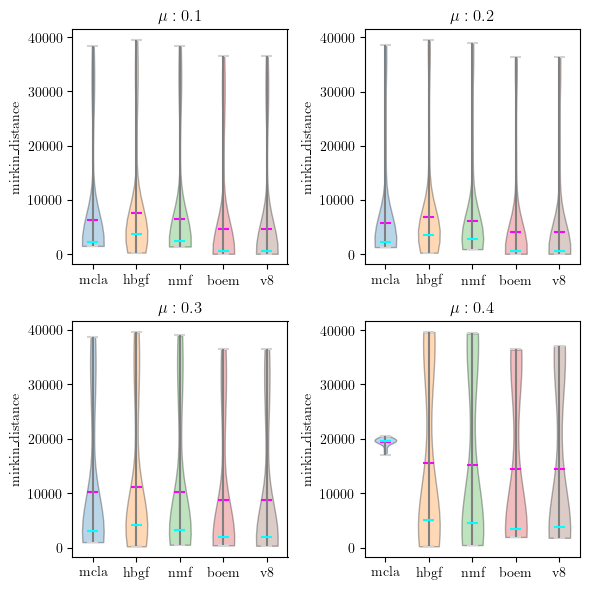

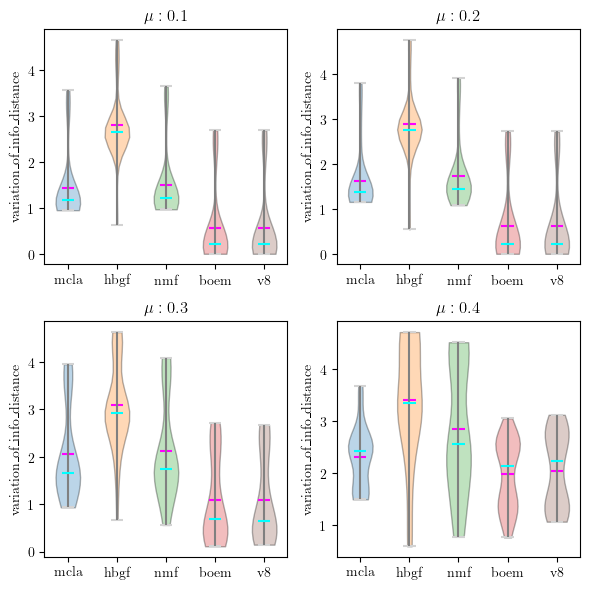

In [4]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.community import LFR_benchmark_graph
from networkx.algorithms import bipartite
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
import matplotlib.colors as mcolors
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica"
    "font.family": "Arial"
})

def plot_distance_distribution(data, ax, colors, distribution_labels, ylabel, title):
    # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
    violin_parts = ax.violinplot(data, showmeans=True, showmedians=True, points=20)

    for k in range(len(data)):
        violin_parts["bodies"][k].set_facecolor(colors[k])
        violin_parts["bodies"][k].set_edgecolor("black")
    violin_parts["cmeans"].set_color("magenta")
    violin_parts["cmedians"].set_color("aqua")
    violin_parts["cbars"].set_color("gray")
    violin_parts["cmaxes"].set_color("lightgray")
    violin_parts["cmins"].set_color("lightgray")

    ax.xaxis.set_ticks(range(1, len(data)+1))
    if (distribution_labels is not None) and (len(distribution_labels) == len(data)):
        ax.xaxis.set_ticklabels(distribution_labels)
    else:
        ax.xaxis.set_ticklabels([])
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    if title is not None:
        ax.set_title(title)

distance_metrics = ["split_joint_distance", "mirkin_distance", "variation_of_info_distance"]

consensus_methods = ["mcla", "hbgf", "nmf", "boem", "v8"]
consensus_methods_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:brown"]

mus = [1, 2, 3, 4]
ns = [200, 1000, 5000]
for n in ns:
    df = pd.read_csv("benchmark-consensus-distance-stats.csv")
    df = df[df["n"] == 200]
    for distance_metric in distance_metrics:
        naxr = 2 
        naxc = 2

        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(nrows=naxr, ncols=naxc)

        axes = []
        for i in range(naxr):
            axr = []
            for j in range(naxc):
                axr.append(fig.add_subplot(gs[i,j]))
            axes.append(axr)
        
        for i in range(naxr):
            for j in range(naxc):
                idx = (i * naxr + j)
                mu = mus[idx]
                data = []
                
                for k in range(len(consensus_methods)):
                    cons_method = consensus_methods[k]
                    mask = None
                    if cons_method == "best_candidate":
                        mask = (df["mu"] == mu) & (df["distance_metric"] == distance_metric) & (df["cons_method"] == cons_method) & (df["optimized_distance"] == distance_metric)
                    else:
                        mask = (df["mu"] == mu) & (df["distance_metric"] == distance_metric) & (df["cons_method"] == cons_method) & (df["optimized_distance"] == "none")
                    df_target = df[mask]
                    data.append(df_target["distance"])
                
                plot_distance_distribution(data, axes[i][j], consensus_methods_colors, consensus_methods, distance_metric, "$\mu:" + str(mu*1.0/10.0)+"$")
        
        plt.tight_layout()
        plt.savefig("benchmark-distance-distribution-"+ "n"+str(n)+ "-" + distance_metric +".pdf")

### Calculate quality of all clusterings of all benchmark graphs

In [ ]:
stats = []

distance_metrics = ["split_joint_distance", "mirkin_distance", "variation_of_info_distance"]
consensus_methods = ["mcla", "hbgf", "nmf", "v1", "boem", "v2", "v3", "v4", "v5", "v7", "v8"]
#consensus_methods = ["v4"]
ns = [200, 1000, 5000]
mus = [1, 2, 3, 4]
#mus = [2]
gammas = [30]
betas = [11]
for n in ns:
    for mu in mus:
        for gamma in gammas:
            for beta in betas:
                P_list = []
                fileprefix = "LFR/" + "n" + str(n) + "/"
                fname = "LFR_n" + str(n) + "_mu0" + str(mu) + "_gamma" + str(gamma) + "_beta" + str(beta)
                graph_file = fileprefix + fname + ".mtx"
                print(graph_file)
                G = None
                with open(graph_file) as f:
                    G = nx.from_scipy_sparse_array(spio.mmread(f), create_using=nx.Graph)
                    gt_clust_lst = read_clust_lst(fileprefix + fname + ".gt")
                    gt_clust_asn = clust_lst_to_asn(gt_clust_lst)

                    common_stat = {}
                    common_stat["mu"] = mu
                    common_stat["n"] = n
                    common_stat["gamma"] = gamma
                    common_stat["beta"] = beta

                    for cons_method in consensus_methods:
                        #print(cons_method)
                        clust_file = fileprefix + fname + "." + cons_method
                        if Path(alg_clust_file).is_file():
                            clust_lst = read_clust_lst(clust_file)
                            clust_asn = clust_lst_to_asn(clust_lst)
                            
                            stat = dict(common_stat)
                            stat["cons_method"] = cons_method
                            stat["ncluster"] = len(clust_lst)

                            F, precision, recall = fscore(gt_clust_lst, clust_lst)

                            stat["fscore"] = F
                            stat["precision"] = precision
                            stat["recall"] = recall

                            clust_lst_temp = clust_asn_to_lst(clust_asn)
                            modularity = nx.community.modularity(G, clust_lst_temp)
                            stat["modularity"] = modularity

                            stat["nmi"] = normalized_mutual_info_score(gt_clust_asn, clust_asn)

                            stats.append(stat)

df = pd.DataFrame(stats)
filename = "benchmark-quality-stats.csv"
df.to_csv(filename, index=False, mode='w', header=True)
#df.to_csv(filename, index=False, mode='a', header=not os.path.exists(filename))

In [ ]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.community import LFR_benchmark_graph
from networkx.algorithms import bipartite
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
import matplotlib.colors as mcolors
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica"
    "font.family": "Arial"
})
import math

quality_metrics = ["precision", "recall", "fscore", "nmi"]

#consensus_methods = ["mcla", "hbgf", "nmf", "boem", "v3", "v4", "v5"]
#consensus_methods_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"]

consensus_methods = ["boem", "v3", "v5", "v7", "v8"]
consensus_methods_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

mus = [1, 2, 3, 4]
ns = [200, 1000, 5000]
for n in ns:
    df = pd.read_csv("benchmark-quality-stats.csv")
    df = df[df["n"] == n]
    
    fig = plt.figure(figsize=(9, 6))
    naxr = 2 
    naxc = 2
    gs = GridSpec(nrows=naxr, ncols=naxc)
    axes = []
    for i in range(naxr):
        axr = []
        for j in range(naxc):
            axr.append(fig.add_subplot(gs[i,j]))
        axes.append(axr)
        
    group_items = list(consensus_methods)
    group_width = 0.7
    bar_width = group_width/len(group_items)
    middle_bar = math.floor(len(group_items) / 2.0)
    even = len(group_items) % 2 == 0
    for i in range(naxr):
        for j in range(naxc):
            idx = (i * naxr + j)
            quality_metric = quality_metrics[idx]
            for k in range(len(consensus_methods)):
                df_target = df[df["cons_method"] == consensus_methods[k]]
                offset = None
                if(even):
                    offset = bar_width / 2.0 + (k - middle_bar) * bar_width
                else:
                    offset = (k - middle_bar) * bar_width
                axes[i][j].bar(df_target["mu"] + offset, df_target[quality_metric], color=consensus_methods_colors[k], width=bar_width, alpha=0.5, edgecolor='black', linewidth=bar_width/10.0, label=consensus_methods[k])
            axes[i][j].set_xlabel("$\mu$")
            axes[i][j].set_ylabel(quality_metric)
            axes[i][j].set_xticks(np.array(mus))
            axes[i][j].set_xticklabels(np.array(mus) / 10.0)
            axes[i][j].grid(axis='y')
            #axes[i][j].legend()
                
    plt.tight_layout()
    plt.savefig("benchmark-quality-"+ "n"+str(n)+".pdf")

In [5]:
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.community import LFR_benchmark_graph
from networkx.algorithms import bipartite
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as mcolors
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica"
    "font.family": "Arial"
})
import math

rt_data = [
    { "n": 200, "mu": 0.1, "cons_method": "mcla", "rt": 149.44089198112488},
    { "n": 200, "mu": 0.2, "cons_method": "mcla", "rt": 162.56297039985657},
    { "n": 200, "mu": 0.3, "cons_method": "mcla", "rt": 206.48962783813477},
    { "n": 200, "mu": 0.4, "cons_method": "mcla", "rt": 292.8949866294861},
    { "n": 1000, "mu": 0.1, "cons_method": "mcla", "rt": 1342.4395899772644},
    { "n": 1000, "mu": 0.2, "cons_method": "mcla", "rt": 1562.3081963062286},
    { "n": 1000, "mu": 0.3, "cons_method": "mcla", "rt": 3899.515527486801},
    { "n": 1000, "mu": 0.4, "cons_method": "mcla", "rt": 7178.795511007309},
    { "n": 5000, "mu": 0.1, "cons_method": "mcla", "rt": 25727.96590065956},
    { "n": 5000, "mu": 0.2, "cons_method": "mcla", "rt": 29203.03486943245},
    { "n": 5000, "mu": 0.3, "cons_method": "mcla", "rt": 78482.53806829453},
    { "n": 5000, "mu": 0.4, "cons_method": "mcla", "rt": 165258.80073308945},
    { "n": 200, "mu": 0.1, "cons_method": "hbgf", "rt": 0.40747547149658203},
    { "n": 200, "mu": 0.2, "cons_method": "hbgf", "rt": 0.41968536376953125},
    { "n": 200, "mu": 0.3, "cons_method": "hbgf", "rt": 0.4672977924346924},
    { "n": 200, "mu": 0.4, "cons_method": "hbgf", "rt": 0.5079178810119629},
    { "n": 1000, "mu": 0.1, "cons_method": "hbgf", "rt": 0.8461880683898926},
    { "n": 1000, "mu": 0.2, "cons_method": "hbgf", "rt": 0.8739335536956787},
    { "n": 1000, "mu": 0.3, "cons_method": "hbgf", "rt": 1.1762597560882568},
    { "n": 1000, "mu": 0.4, "cons_method": "hbgf", "rt": 1.426685094833374},
    { "n": 5000, "mu": 0.1, "cons_method": "hbgf", "rt": 4.917860984802246},
    { "n": 5000, "mu": 0.2, "cons_method": "hbgf", "rt": 4.905524730682373},
    { "n": 5000, "mu": 0.3, "cons_method": "hbgf", "rt": 6.563857078552246},
    { "n": 5000, "mu": 0.4, "cons_method": "hbgf", "rt": 8.91361403465271},
    { "n": 200, "mu": 0.1, "cons_method": "nmf", "rt": 5.5484983921051025},
    { "n": 200, "mu": 0.2, "cons_method": "nmf", "rt": 4.889721632003784},
    { "n": 200, "mu": 0.3, "cons_method": "nmf", "rt": 4.957129716873169},
    { "n": 200, "mu": 0.4, "cons_method": "nmf", "rt": 5.1594343185424805},
    { "n": 1000, "mu": 0.1, "cons_method": "nmf", "rt": 171.75516819953918},
    { "n": 1000, "mu": 0.2, "cons_method": "nmf", "rt": 264.1879839897156},
    { "n": 1000, "mu": 0.3, "cons_method": "nmf", "rt": 341.15653467178345},
    { "n": 1000, "mu": 0.4, "cons_method": "nmf", "rt": 335.9212169647217},
    { "n": 5000, "mu": 0.1, "cons_method": "nmf", "rt": 15585.253784656525},
    { "n": 5000, "mu": 0.2, "cons_method": "nmf", "rt": 18174.84340786934},
    { "n": 5000, "mu": 0.3, "cons_method": "nmf", "rt": 25836.429513454437},
    { "n": 5000, "mu": 0.4, "cons_method": "nmf", "rt": 38797.094098091125},
    { "n": 200, "mu": 0.1, "cons_method": "boem", "rt": 0.4165503978729248},
    { "n": 200, "mu": 0.2, "cons_method": "boem", "rt": 0.42778563499450684},
    { "n": 200, "mu": 0.3, "cons_method": "boem", "rt": 0.5192949771881104},
    { "n": 200, "mu": 0.4, "cons_method": "boem", "rt": 0.6321694850921631},
    { "n": 1000, "mu": 0.1, "cons_method": "boem", "rt": 6.6967573165893555},
    { "n": 1000, "mu": 0.2, "cons_method": "boem", "rt": 8.391771078109741},
    { "n": 1000, "mu": 0.3, "cons_method": "boem", "rt": 10.886692523956299},
    { "n": 1000, "mu": 0.4, "cons_method": "boem", "rt": 12.241299867630005},
    { "n": 5000, "mu": 0.1, "cons_method": "boem", "rt": 257.0957062244415},
    { "n": 5000, "mu": 0.2, "cons_method": "boem", "rt": 247.48991179466248},
    { "n": 5000, "mu": 0.3, "cons_method": "boem", "rt": 269.07662653923035},
    { "n": 5000, "mu": 0.4, "cons_method": "boem", "rt": 305.25197196006775},
    { "n": 200, "mu": 0.1, "cons_method": "v3", "rt": 0.20238280296325684},
    { "n": 200, "mu": 0.2, "cons_method": "v3", "rt": 0.21066570281982422},
    { "n": 200, "mu": 0.3, "cons_method": "v3", "rt": 0.27460193634033203},
    { "n": 200, "mu": 0.4, "cons_method": "v3", "rt": 0.4301011562347412},
    { "n": 1000, "mu": 0.1, "cons_method": "v3", "rt": 2.2396063804626465},
    { "n": 1000, "mu": 0.2, "cons_method": "v3", "rt": 2.9395501613616943},
    { "n": 1000, "mu": 0.3, "cons_method": "v3", "rt": 3.9071197509765625},
    { "n": 1000, "mu": 0.4, "cons_method": "v3", "rt": 5.536072492599487},
    { "n": 5000, "mu": 0.1, "cons_method": "v3", "rt": 41.573002576828},
    { "n": 5000, "mu": 0.2, "cons_method": "v3", "rt": 41.824567794799805},
    { "n": 5000, "mu": 0.3, "cons_method": "v3", "rt": 49.67441773414612},
    { "n": 5000, "mu": 0.4, "cons_method": "v3", "rt": 53.16094374656677},
    { "n": 200, "mu": 0.1, "cons_method": "v4", "rt": 1.3950552940368652},
    { "n": 200, "mu": 0.2, "cons_method": "v4", "rt": 1.3167805671691895},
    { "n": 200, "mu": 0.3, "cons_method": "v4", "rt": 2.109605073928833},
    { "n": 200, "mu": 0.4, "cons_method": "v4", "rt": 1.858361005783081},
    { "n": 1000, "mu": 0.1, "cons_method": "v4", "rt": 21.3703191280365},
    { "n": 1000, "mu": 0.2, "cons_method": "v4", "rt": 22.90269923210144},
    { "n": 1000, "mu": 0.3, "cons_method": "v4", "rt": 23.381633520126343},
    { "n": 1000, "mu": 0.4, "cons_method": "v4", "rt": 36.66318416595459},
    { "n": 5000, "mu": 0.1, "cons_method": "v4", "rt": 109.35808682441711},
    { "n": 5000, "mu": 0.2, "cons_method": "v4", "rt": 168.69196343421936},
    { "n": 5000, "mu": 0.3, "cons_method": "v4", "rt": 114.65513181686401},
    { "n": 5000, "mu": 0.4, "cons_method": "v4", "rt": 172.6126413345337},
    { "n": 200, "mu": 0.1, "cons_method": "v5", "rt": 1.5365149974822998},
    { "n": 200, "mu": 0.2, "cons_method": "v5", "rt": 2.2426939010620117},
    { "n": 200, "mu": 0.3, "cons_method": "v5", "rt": 1.678490161895752},
    { "n": 200, "mu": 0.4, "cons_method": "v5", "rt": 2.2428464889526367},
    { "n": 1000, "mu": 0.1, "cons_method": "v5", "rt": 24.272643566131592},
    { "n": 1000, "mu": 0.2, "cons_method": "v5", "rt": 29.0472674369812},
    { "n": 1000, "mu": 0.3, "cons_method": "v5", "rt": 34.028849363327026},
    { "n": 1000, "mu": 0.4, "cons_method": "v5", "rt": 28.32345175743103},
    { "n": 5000, "mu": 0.1, "cons_method": "v5", "rt": 149.31756925582886},
    { "n": 5000, "mu": 0.2, "cons_method": "v5", "rt": 143.45976519584656},
    { "n": 5000, "mu": 0.3, "cons_method": "v5", "rt": 172.6393985748291},
    { "n": 5000, "mu": 0.4, "cons_method": "v5", "rt": 195.28433871269226},
    { "n": 200, "mu": 0.1, "cons_method": "v7", "rt": 0.2931818962097168},
    { "n": 200, "mu": 0.2, "cons_method": "v7", "rt": 0.5080595016479492},
    { "n": 200, "mu": 0.3, "cons_method": "v7", "rt": 0.5090279579162598},
    { "n": 200, "mu": 0.4, "cons_method": "v7", "rt": 0.8351304531097412},
    { "n": 1000, "mu": 0.1, "cons_method": "v7", "rt": 3.787137985229492},
    { "n": 1000, "mu": 0.2, "cons_method": "v7", "rt": 6.510969638824463},
    { "n": 1000, "mu": 0.3, "cons_method": "v7", "rt": 9.996269226074219},
    { "n": 1000, "mu": 0.4, "cons_method": "v7", "rt": 9.985952615737915},
    { "n": 5000, "mu": 0.1, "cons_method": "v7", "rt": 22.808717489242554},
    { "n": 5000, "mu": 0.2, "cons_method": "v7", "rt": 32.955440044403076},
    { "n": 5000, "mu": 0.3, "cons_method": "v7", "rt": 51.13420104980469},
    { "n": 5000, "mu": 0.4, "cons_method": "v7", "rt": 64.52692699432373},
    { "n": 200, "mu": 0.1, "cons_method": "v8", "rt": 0.23626208305358887},
    { "n": 200, "mu": 0.2, "cons_method": "v8", "rt": 0.27086710929870605},
    { "n": 200, "mu": 0.3, "cons_method": "v8", "rt": 0.3323040008544922},
    { "n": 200, "mu": 0.4, "cons_method": "v8", "rt": 0.4406752586364746},
    { "n": 1000, "mu": 0.1, "cons_method": "v8", "rt": 3.214815378189087},
    { "n": 1000, "mu": 0.2, "cons_method": "v8", "rt": 3.8215553760528564},
    { "n": 1000, "mu": 0.3, "cons_method": "v8", "rt": 6.482314825057983},
    { "n": 1000, "mu": 0.4, "cons_method": "v8", "rt": 7.608185529708862},
    { "n": 5000, "mu": 0.1, "cons_method": "v8", "rt": 16.092422008514404},
    { "n": 5000, "mu": 0.2, "cons_method": "v8", "rt": 25.142757177352905},
    { "n": 5000, "mu": 0.3, "cons_method": "v8", "rt": 39.89899730682373},
    { "n": 5000, "mu": 0.4, "cons_method": "v8", "rt": 38.94822144508362}
]
df = pd.DataFrame(rt_data)

quality_metrics = ["precision", "recall", "fscore", "nmi"]
#consensus_methods = ["mcla", "hbgf", "nmf", "boem", "v3", "v4", "v5"]
#consensus_methods_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"]

consensus_methods = ["boem", "v8"]
consensus_methods_colors = ["tab:red", "tab:brown"]

mus = [0.1, 0.2, 0.3, 0.4]
ns = [200, 1000, 5000]

fig = plt.figure(figsize=(9, 6))
naxr = 2 
naxc = 2
gs = GridSpec(nrows=naxr, ncols=naxc)
axes = []
for i in range(naxr):
    axr = []
    for j in range(naxc):
        axr.append(fig.add_subplot(gs[i,j]))
    axes.append(axr)

for i in range(naxr):
    axr = []
    for j in range(naxc):
        idx = (i * naxr + j)
        mu = mus[idx]
        for k in range(len(consensus_methods)):
            df_target = df[(df["mu"] == mu) & (df["cons_method"] == consensus_methods[k])]
            axes[i][j].plot(df_target["n"], df_target["rt"], color=consensus_methods_colors[k], marker='x', label=consensus_methods[k])
            pass
        axes[i][j].set_title("$\mu:" + str(mu)+"$")
        axes[i][j].set_xscale('log', base=2)
        axes[i][j].set_yscale('log', base=2)
        axes[i][j].grid(True, axis='both', which='both', alpha=0.5)
        axes[i][j].set_xticks(ns)
        axes[i][j].set_xticklabels(ns)
        axes[i][j].set_xlabel("n")
        axes[i][j].set_ylabel("runtime (sec)")
        axes[i][j].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.tight_layout()
plt.savefig("benchmark-runtime.pdf")